# HMM Simulation for Unfair Coin Problem
> A programming introduction to HMMs for unfair coin problem

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In this notebook we shall create a Hidden Markov Model [1] for the Unfair Coin problem. This problem is similar to an earlier [post](https://nipunbatra.github.io/blog/ml/2013/06/01/hmm_simulate.html) In short the problem is as follows: 
There may be two coin- one fair and the other biased. The biased die is much more likely to produce a H than T. With the fair coin, both H and T are equally likely. 

The different components of the Discrete HMM are as follows:

* **Observed States**  : H or T
* **Hidden States**    : Fair or Biased Die
* **Prior (pi)**            : Probability that the first throw is made from a fair or a biased die, which is : Pr (first throw is fair) and Pr (first throw is biased), which is represented as a 1 X 2 row matrix
* **Transition Matrix (A)**: Matrix encoding the probability of the 4 possible transition between fair and biased die, which are: Fair-> Fair, Fair-> Biased, Biased-> Fair and Biased->Biased, which is represented as a 2 X 2 matrix
* **Emission Matrix (B)**  : Matrix encoding the probability of an observation given the hidden state. It is a 2 X 2 Matrix


Next, we import the basic set of libraries used for matrix manipulation and for plotting.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib
#Setting Font Size as 20
matplotlib.rcParams.update({'font.size': 20})

Next, we define the different components of HMM which were described above.

In [7]:
'''
Pi : Fair coin is more likely for t=1

A  : The coin thrower likes to keep in one state (fair/biased), and the tranisition from 
1. Biased->Biased: .90
2. Biased->Fair=1-.90=.10
3. Fair->Biased: 1-.90=.1
4. Fair-> Fair : .90



B
'''
pi=np.array([0.6,0.4])
A=np.array([[.9,.1],[.1,.9]])
B=np.array([[0.7, 0.3],[.5,.5]])

Now based on these probability sequences we need to produce a sequence of **observed** and **hidden** states. We use the notion of weighted sampling, which basically means that terms/states with higher probabilies assigned to them are more likely to be selected/sampled. For example,let us consider the starting state. For this we need to use the **pi** matrix, since that encodes the likiliness of starting in a particular state. We observe that for starting in **Biased** state the probability is .6 and 1.5 times that of starting in **Fair** state. Thus, it is much more likely that we start in Fair state. We use **Fitness Proportionate Selection** [3] to sample states based on weights (probability). For selection of starting state we would proceed as follows:

* We choose a random value between 0 and 1
* We iterate over the list of values (prior) and iteratively subtract the value at current position from the number which we chose at random and as soon as it becomes negative, we return the index. Let us demonstrate this with a function.

In [8]:
'''
Returns next state according to weigted probability array. Code based on Weighted random generation in Python [4]
'''
def next_state(weights, print_random=False):
    choice = random.random() * sum(weights)
    if print_random:
        print(f"Choice: {choice}")
    for i, w in enumerate(weights):
        choice -= w
        if choice < 0:
            return i

In [17]:
next_state([0.8, 0.2], print_random=True)

Choice: 0.0857069787975111


0

In [18]:
next_state([0.8, 0.2], print_random=True)

Choice: 0.36222917901303864


0

In [19]:
next_state([0.8, 0.2], print_random=True)

Choice: 0.20068873387672292


0

In [20]:
next_state([0.8, 0.2], print_random=True)

Choice: 0.6783569698926452


0

We test the above function by making a call to it 1000 times and then we try to see how many times do we get a 0 (Fair) wrt 1 (Biased), 
given the **pi** vector.

In [24]:
count=0
for i in range(1000):
    count+=next_state(pi)
print(f"Expected number of Biased states: {1000-count}")
print(f"Expected number of Fair states: {count}")

Expected number of Biased states: 609
Expected number of Fair states: 391


In [25]:
count=0
for i in range(1000):
    count+=next_state(pi)
print(f"Expected number of Biased states: {1000-count}")
print(f"Expected number of Fair states: {count}")

Expected number of Biased states: 598
Expected number of Fair states: 402


Thus, we can see that we get approximately twice the ratio of biased to fair as we had expected.

Next, we write the following functions:

* create_hidden_sequence (pi,A,length): which creates a hidden sequence (Markov Chain) of desired length based on **Pi** and **A**. The algorithm
followed is as follows: We choose the first state as described above. Next on the basis of current state, we see it's transition matrix and assign
the next state by weighted sampling (by invoking next_state with argument as A[current_state])
* create_observed_sequence (hidden_sequence,B): which create an observed sequence based on hidden states and associated **B**. Based on current hidden state, we use it's emission parameters to sample the observation.

    

In [26]:
def create_hidden_sequence(pi,A,length):
    out=[None]*length
    out[0]=next_state(pi)
    for i in range(1,length):
        out[i]=next_state(A[out[i-1]])
    return out
   
def create_observation_sequence(hidden_sequence,B):
    length=len(hidden_sequence)
    out=[None]*length
    for i in range(length):
        out[i]=next_state(B[hidden_sequence[i]])
    return out

Thus, using these functions and the HMM paramters we decided earlier, we create length 1000 sequence for hidden and observed states.

In [27]:
hidden=np.array(create_hidden_sequence(pi,A,1000))
observed=np.array(create_observation_sequence(hidden,B))

In [28]:
'''Group all contiguous values in tuple. Recipe picked from Stack Overflow [5]'''
def group(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group
    
'''Create tuples of the form (start, number_of_continuous values'''
def create_tuple(x):
    return [(a,b-a+1) for (a,b) in x]

In [29]:
#Tuples of form index value, number of continuous values corresponding to Fair State
indices_hidden_fair=np.where(hidden==0)[0]
tuples_contiguous_values_fair=list(group(indices_hidden_fair))
tuples_start_break_fair=create_tuple(tuples_contiguous_values_fair)

#Tuples of form index value, number of continuous values corresponding to Biased State
indices_hidden_biased=np.where(hidden==1)[0]
tuples_contiguous_values_biased=list(group(indices_hidden_biased))
tuples_start_break_biased=create_tuple(tuples_contiguous_values_biased)

#Tuples for observations
observation_tuples=[]
for i in range(2):
    observation_tuples.append(create_tuple(group(list(np.where(observed==i)[0]))))

Now we plot the hidden and observation sequences

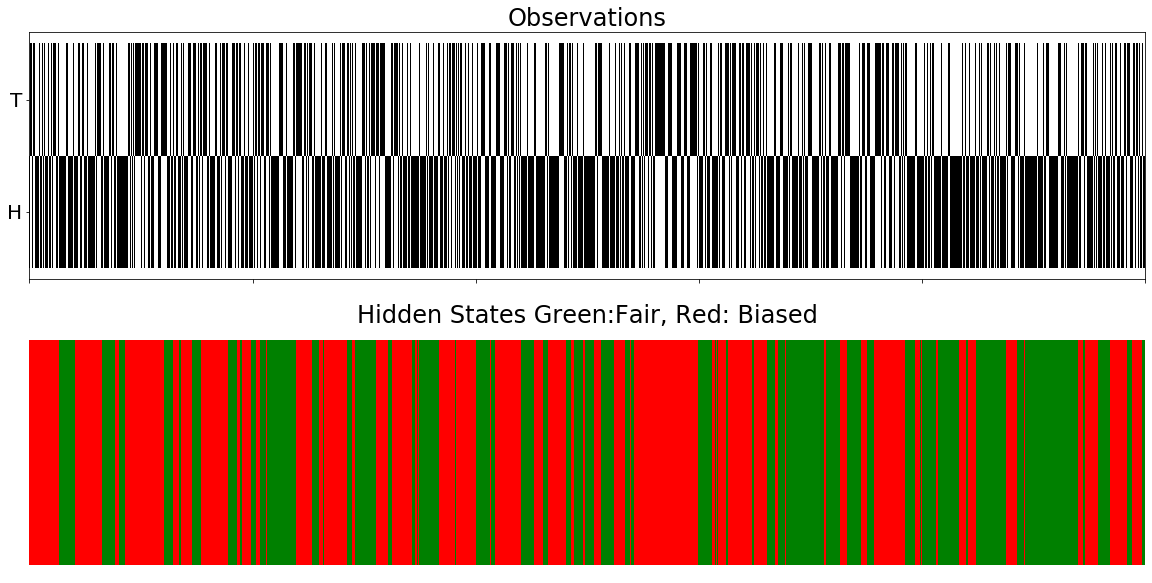

In [49]:
fig, ax = plt.subplots(figsize=(20, 10),nrows=2,sharex=True )

ax[0].set_xlim((0,1000));
ax[0].set_title('Observations');
for i in range(2):
    ax[0].broken_barh(observation_tuples[i],(i+0.5,1),facecolor='k');
ax[1].set_title('Hidden States Green:Fair, Red: Biased')
ax[1].broken_barh(tuples_start_break_fair,(0,1),facecolor='g')
ax[1].broken_barh(tuples_start_break_biased,(0,1),facecolor='r')

ax[1].axis("off")
ax[0].set_yticks([1, 2])
ax[0].set_yticklabels(['H','T']);

## References

1. http://en.wikipedia.org/wiki/Hidden_Markov_model
2. http://www.stanford.edu/class/stats366/hmmR2.html
3. http://en.wikipedia.org/wiki/Fitness_proportionate_selection
4. http://eli.thegreenplace.net/2010/01/22/weighted-random-generation-in-python/
5. http://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list
